# Introduction
- nb45の編集
- いくつかのモデルを使って見る
- ref:
    > https://www.kaggle.com/artgor/validation-feature-selection-interpretation-etc


- features
    - distance とその統計量  
    - cos features  
    - dist_interact  
    - openbabelcharge 特徴量(nb32)
    - fc(nb47)

# Import everything I need :)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import time
import multiprocessing
import glob
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import NearestNeighbors
from sklearn import linear_model
from fastprogress import progress_bar

# Preparation

In [2]:
nb = 50
isSmallSet = True
length = 500000
# length = 20000

In [3]:
pd.set_option('display.max_columns', 200)

In [4]:
# use atomic numbers to recode atomic names
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

In [5]:
file_path = '../input/champs-scalar-coupling/'
glob.glob(file_path + '*')

['../input/champs-scalar-coupling/scalar_coupling_contributions.csv',
 '../input/champs-scalar-coupling/magnetic_shielding_tensors.csv',
 '../input/champs-scalar-coupling/structures.csv',
 '../input/champs-scalar-coupling/test.csv',
 '../input/champs-scalar-coupling/dipole_moments.csv',
 '../input/champs-scalar-coupling/potential_energy.csv',
 '../input/champs-scalar-coupling/sample_submission.csv',
 '../input/champs-scalar-coupling/train.csv',
 '../input/champs-scalar-coupling/nb33_train_dist-interaction.csv',
 '../input/champs-scalar-coupling/test_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv',
 '../input/champs-scalar-coupling/nb29_fc_test_feature.csv',
 '../input/champs-scalar-coupling/train_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv',
 '../input/champs-scalar-coupling/nb33_test_dist-interaction.csv',
 '../input/champs-scalar-coupling/mulliken_charges.csv',
 '../input/champs-scalar-coupling/nb29_fc_train_feature.csv']

In [6]:
# train
path = file_path + 'train.csv'
if isSmallSet:
    train = pd.read_csv(path) [:length]
else:
    train = pd.read_csv(path)

In [7]:
# test
path = file_path + 'test.csv'
if isSmallSet:
    test = pd.read_csv(path)[:length]
else:
    test = pd.read_csv(path)

In [8]:
# structure
path = file_path + 'structures.csv'
structures = pd.read_csv(path)

In [9]:
# fc_train
path = file_path + 'nb29_fc_train_feature.csv'
if isSmallSet:
    fc_train = pd.read_csv(path)[:length]
else:
    fc_train = pd.read_csv(path)

In [10]:
# fc_test
path = file_path + 'nb29_fc_test_feature.csv'
if isSmallSet:
    fc_test = pd.read_csv(path)[:length]
else:
    fc_test = pd.read_csv(path)

In [11]:
# train dist-interact
path = file_path + 'nb33_train_dist-interaction.csv'
if isSmallSet:
    dist_interact_train = pd.read_csv(path)[:length]
else:
    dist_interact_train = pd.read_csv(path)

In [12]:
# test dist-interact
path = file_path + 'nb33_test_dist-interaction.csv'
if isSmallSet:
    dist_interact_test = pd.read_csv(path)[:length]
else:
    dist_interact_test = pd.read_csv(path)

In [13]:
# ob charge train
path = file_path + 'train_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv'
if isSmallSet:
    ob_charge_train = pd.read_csv(path)[:length].drop(['Unnamed: 0', 'error'], axis=1)
else:
    ob_charge_train = pd.read_csv(path).drop(['Unnamed: 0', 'error'], axis=1)

In [14]:
# ob charge test
path = file_path + 'test_ob_charges_V7EstimatioofMullikenChargeswithOpenBabel.csv'
if isSmallSet:
    ob_charge_test = pd.read_csv(path)[:length].drop(['Unnamed: 0', 'error'], axis=1)
else:
    ob_charge_test = pd.read_csv(path).drop(['Unnamed: 0', 'error'], axis=1)

In [15]:
len(test), len(fc_test)

(500000, 500000)

In [16]:
len(train), len(fc_train)

(500000, 500000)

In [17]:
if isSmallSet:
    print('using SmallSet !!')
    print('-------------------')

print(f'There are {train.shape[0]} rows in train data.')
print(f'There are {test.shape[0]} rows in test data.')

print(f"There are {train['molecule_name'].nunique()} distinct molecules in train data.")
print(f"There are {test['molecule_name'].nunique()} distinct molecules in test data.")
print(f"There are {train['atom_index_0'].nunique()} unique atoms.")
print(f"There are {train['type'].nunique()} unique types.")

using SmallSet !!
-------------------
There are 500000 rows in train data.
There are 500000 rows in test data.
There are 10434 distinct molecules in train data.
There are 11100 distinct molecules in test data.
There are 25 unique atoms.
There are 8 unique types.


---
## myFunc
**metrics**

In [18]:
def kaggle_metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)

---
**momory**

In [19]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Feature Engineering

Build Distance Dataset

In [20]:
def build_type_dataframes(base, structures, coupling_type):
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    base = base.reset_index()
    base['id'] = base['id'].astype('int32')
    structures = structures[structures['molecule_name'].isin(base['molecule_name'])]
    return base, structures

# a,b = build_type_dataframes(train, structures, '1JHN')

In [21]:
def add_coordinates(base, structures, index):
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_name', f'atom_index_{index}'],
                  right_on=['molecule_name', 'atom_index']).drop(['atom_index'], axis=1)
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df

In [22]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_name', 'atom_index_0', 'atom_index_1'])
    return df

In [23]:
def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['molecule_name'],
                  right_on=['molecule_name'])
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [24]:
def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))

def add_distance_to_center(df):
    df['d_c'] = ((
        (df['x_c'] - df['x'])**np.float32(2) +
        (df['y_c'] - df['y'])**np.float32(2) + 
        (df['z_c'] - df['z'])**np.float32(2)
    )**np.float32(0.5))

def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

In [25]:
def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)

In [26]:
def add_n_atoms(base, structures):
    dfs = structures['molecule_name'].value_counts().rename('n_atoms').to_frame()
    return pd.merge(base, dfs, left_on='molecule_name', right_index=True)

In [27]:
def build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in some_csv:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
        
    add_center(atoms)
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)

    atoms = merge_all_atoms(atoms, structures)
    
    add_distance_to_center(atoms)
    
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms.sort_values(['molecule_name', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_name', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    atoms = atoms.set_index(['molecule_name', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()
    
#     # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
#     atoms['molecule_name'] = atoms['molecule_name'].astype('int32')
    
    full = add_atoms(base, atoms)
    add_distances(full)
    
    full.sort_values('id', inplace=True)
    
    return full

In [28]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = ['id', 'molecule_name', 'atom_index_1', 'atom_index_0']
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    return df[labels]

In [29]:
atoms = structures['atom'].values
types_train = train['type'].values
types_test = test['type'].values
structures['atom'] = structures['atom'].replace(ATOMIC_NUMBERS).astype('int8')
fulls_train = []
fulls_test  = []
for type_ in progress_bar(train['type'].unique()):
    full_train = build_couple_dataframe(train, structures, type_, n_atoms=10)
    full_test  = build_couple_dataframe(test, structures, type_, n_atoms=10)
    full_train = take_n_atoms(full_train, 10)
    full_test  = take_n_atoms(full_test, 10)
    fulls_train.append(full_train)
    fulls_test.append(full_test)
    
structures['atom'] = atoms
train = pd.concat(fulls_train).sort_values(by=['id']) #, axis=0)
test  = pd.concat(fulls_test).sort_values(by=['id']) #, axis=0)
train['type'] = types_train
test['type'] = types_test
train = train.fillna(0)
test  = test.fillna(0)

<br>
<br>
dist-interact

In [30]:
train['dist_interact'] = dist_interact_train.values
test['dist_interact'] = dist_interact_test.values

<br>
<br>
basic

In [31]:
def map_atom_info(df_1,df_2, atom_idx):
    df = pd.merge(df_1, df_2, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    df = df.drop('atom_index', axis=1)
    return df


# structure and ob_charges
ob_charge = pd.concat([ob_charge_train, ob_charge_test])
merge = pd.merge(ob_charge, structures, how='left',
                  left_on  = ['molecule_name', 'atom_index'],
                  right_on = ['molecule_name', 'atom_index'])
for atom_idx in [0,1]:
    train = map_atom_info(train, merge, atom_idx)
    test  = map_atom_info(test,  merge, atom_idx)
    
    train = train.rename(columns={
                                        'atom': f'atom_{atom_idx}',
                                        'x': f'x_{atom_idx}',
                                        'y': f'y_{atom_idx}',
                                        'z': f'z_{atom_idx}',
                                        'eem': f'eem_{atom_idx}',
                                     'mmff94': f'mmff94_{atom_idx}',
                                  'gasteiger': f'gasteiger_{atom_idx}', 
                                        'qeq': f'qeq_{atom_idx}',
                                      'qtpie': f'qtpie_{atom_idx}', 
                                  'eem2015ha': f'eem2015ha_{atom_idx}', 
                                  'eem2015hm': f'eem2015hm_{atom_idx}', 
                                  'eem2015hn': f'eem2015hn_{atom_idx}', 
                                  'eem2015ba': f'eem2015ba_{atom_idx}', 
                                  'eem2015bm': f'eem2015bm_{atom_idx}', 
                                  'eem2015bn': f'eem2015bn_{atom_idx}',})
    test = test.rename(columns={
                                        'atom': f'atom_{atom_idx}',
                                        'x': f'x_{atom_idx}',
                                        'y': f'y_{atom_idx}',
                                        'z': f'z_{atom_idx}',
                                        'eem': f'eem_{atom_idx}',
                                     'mmff94': f'mmff94_{atom_idx}',
                                  'gasteiger': f'gasteiger_{atom_idx}', 
                                        'qeq': f'qeq_{atom_idx}', 
                                      'qtpie': f'qtpie_{atom_idx}', 
                                  'eem2015ha': f'eem2015ha_{atom_idx}', 
                                  'eem2015hm': f'eem2015hm_{atom_idx}', 
                                  'eem2015hn': f'eem2015hn_{atom_idx}', 
                                  'eem2015ba': f'eem2015ba_{atom_idx}', 
                                  'eem2015bm': f'eem2015bm_{atom_idx}', 
                                  'eem2015bn': f'eem2015bn_{atom_idx}'})
#     test  =  test.rename(columns={'atom': f'atom_{atom_idx}',
#                                         'x': f'x_{atom_idx}',
#                                         'y': f'y_{atom_idx}',
#                                         'z': f'z_{atom_idx}'})

# ob_charges
# train = map_atom_info(train, ob_charge_train, 0)
# test  = map_atom_info(test,  ob_charge_test,  0)
# train = map_atom_info(train, ob_charge_train, 1)
# test  = map_atom_info(test,  ob_charge_test,  1)

<br>
<br>
type0

In [32]:
def create_type0(df):
    df['type_0'] = df['type'].apply(lambda x : x[0])
    return df
# train['type_0'] = train['type'].apply(lambda x: x[0])
# test['type_0'] = test['type'].apply(lambda x: x[0])

<br>
<br>
distances

In [33]:
def distances(df):
    df_p_0 = df[['x_0', 'y_0', 'z_0']].values
    df_p_1 = df[['x_1', 'y_1', 'z_1']].values
    
    df['dist'] = np.linalg.norm(df_p_0 - df_p_1, axis=1)
    df['dist_x'] = (df['x_0'] - df['x_1']) ** 2
    df['dist_y'] = (df['y_0'] - df['y_1']) ** 2
    df['dist_z'] = (df['z_0'] - df['z_1']) ** 2
    
    return df

# train = distances(train)
# test  = distances(test)

<br>
<br>
統計量

In [34]:
def create_features(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    df[f'molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
    df[f'molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df[f'molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
    df[f'molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df[f'molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df[f'molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
    df[f'molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
    df[f'molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df[f'molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df[f'molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df[f'molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df[f'molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df[f'molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df[f'molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df[f'molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df[f'molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df[f'molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df[f'molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df[f'molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    df[f'molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df[f'molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df[f'molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df[f'molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df[f'molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df[f'molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df[f'molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df[f'molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df[f'molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df[f'molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df[f'molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df[f'molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    df[f'molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df[f'molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df[f'molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df[f'molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df[f'molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df[f'molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
    df[f'molecule_type_0_dist_std'] = df.groupby(['molecule_name', 'type_0'])['dist'].transform('std')
    df[f'molecule_type_0_dist_std_diff'] = df[f'molecule_type_0_dist_std'] - df['dist']
    df[f'molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
    df[f'molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
    df[f'molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / df['dist']
    df[f'molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
    df[f'molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')
    df[f'molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
    df[f'molecule_type_dist_std_diff'] = df[f'molecule_type_dist_std'] - df['dist']
    # fc
    df[f'molecule_type_fc_max'] = df.groupby(['molecule_name', 'type'])['fc'].transform('max')
    df[f'molecule_type_fc_min'] = df.groupby(['molecule_name', 'type'])['fc'].transform('min')
    df[f'molecule_type_fc_std'] = df.groupby(['molecule_name', 'type'])['fc'].transform('std')
    df[f'molecule_type_fc_std_diff'] = df[f'molecule_type_fc_std'] - df['fc']
    return df

angle features

In [35]:
def map_atom_info(df_1,df_2, atom_idx):
    df = pd.merge(df_1, df_2, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    df = df.drop('atom_index', axis=1)

    return df

def create_closest(df):
    df_temp=df.loc[:,["molecule_name","atom_index_0","atom_index_1","dist","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()
    df_temp_=df_temp.copy()
    df_temp_= df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
                                       'atom_index_1': 'atom_index_0',
                                       'x_0': 'x_1',
                                       'y_0': 'y_1',
                                       'z_0': 'z_1',
                                       'x_1': 'x_0',
                                       'y_1': 'y_0',
                                       'z_1': 'z_0'})
    df_temp=pd.concat(objs=[df_temp,df_temp_],axis=0)

    df_temp["min_distance"]=df_temp.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df_temp= df_temp[df_temp["min_distance"]==df_temp["dist"]]

    df_temp=df_temp.drop(['x_0','y_0','z_0','min_distance', 'dist'], axis=1)
    df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                     'atom_index_1': 'atom_index_closest',
                                     'distance': 'distance_closest',
                                     'x_1': 'x_closest',
                                     'y_1': 'y_closest',
                                     'z_1': 'z_closest'})

    for atom_idx in [0,1]:
        df = map_atom_info(df,df_temp, atom_idx)
        df = df.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
                                        'distance_closest': f'distance_closest_{atom_idx}',
                                        'x_closest': f'x_closest_{atom_idx}',
                                        'y_closest': f'y_closest_{atom_idx}',
                                        'z_closest': f'z_closest_{atom_idx}'})
    return df

def add_cos_features(df):
    df["distance_0"]=((df['x_0']-df['x_closest_0'])**2+(df['y_0']-df['y_closest_0'])**2+(df['z_0']-df['z_closest_0'])**2)**(1/2)
    df["distance_1"]=((df['x_1']-df['x_closest_1'])**2+(df['y_1']-df['y_closest_1'])**2+(df['z_1']-df['z_closest_1'])**2)**(1/2)
    df["vec_0_x"]=(df['x_0']-df['x_closest_0'])/df["distance_0"]
    df["vec_0_y"]=(df['y_0']-df['y_closest_0'])/df["distance_0"]
    df["vec_0_z"]=(df['z_0']-df['z_closest_0'])/df["distance_0"]
    df["vec_1_x"]=(df['x_1']-df['x_closest_1'])/df["distance_1"]
    df["vec_1_y"]=(df['y_1']-df['y_closest_1'])/df["distance_1"]
    df["vec_1_z"]=(df['z_1']-df['z_closest_1'])/df["distance_1"]
    df["vec_x"]=(df['x_1']-df['x_0'])/df["dist"]
    df["vec_y"]=(df['y_1']-df['y_0'])/df["dist"]
    df["vec_z"]=(df['z_1']-df['z_0'])/df["dist"]
    df["cos_0_1"]=df["vec_0_x"]*df["vec_1_x"]+df["vec_0_y"]*df["vec_1_y"]+df["vec_0_z"]*df["vec_1_z"]
    df["cos_0"]=df["vec_0_x"]*df["vec_x"]+df["vec_0_y"]*df["vec_y"]+df["vec_0_z"]*df["vec_z"]
    df["cos_1"]=df["vec_1_x"]*df["vec_x"]+df["vec_1_y"]*df["vec_y"]+df["vec_1_z"]*df["vec_z"]
    df=df.drop(['vec_0_x','vec_0_y','vec_0_z','vec_1_x','vec_1_y','vec_1_z','vec_x','vec_y','vec_z'], axis=1)
    return df



In [36]:
%%time

print('add fc')
print(len(train), len(test))
train['fc'] = fc_train.values
test['fc']  = fc_test.values

print('type0')
print(len(train), len(test))
train = create_type0(train)
test  = create_type0(test)

print('distances')
print(len(train), len(test))
train = distances(train)
test  = distances(test)

print('create_featueres')
print(len(train), len(test))
train = create_features(train)
test  = create_features(test)

print('create_closest')
print(len(train), len(test))
train = create_closest(train)
test  = create_closest(test)
train.drop_duplicates(inplace=True, subset=['id'])   # なぜかtrainの行数が増えるバグが発生
train = train.reset_index(drop=True)

print('add_cos_features')
print(len(train), len(test))
train = add_cos_features(train)
test  = add_cos_features(test)

add fc
500000 500000
type0
500000 500000
distances
500000 500000
create_featueres
500000 500000
create_closest
500000 500000
add_cos_features
500000 500000
CPU times: user 17.3 s, sys: 32 s, total: 49.3 s
Wall time: 49.3 s


---
<br>
<br>
<br>
nanがある特徴量を削除

In [37]:
drop_feats = train.columns[train.isnull().sum(axis=0) != 0].values
drop_feats

array(['dist_interact', 'molecule_atom_index_0_x_1_std',
       'molecule_atom_index_0_y_1_mean_div',
       'molecule_atom_index_0_y_1_std', 'molecule_atom_index_0_z_1_std',
       'molecule_atom_index_0_dist_std',
       'molecule_atom_index_0_dist_std_diff',
       'molecule_atom_index_0_dist_std_div',
       'molecule_atom_index_1_dist_std',
       'molecule_atom_index_1_dist_std_diff',
       'molecule_atom_index_1_dist_std_div', 'molecule_atom_1_dist_std',
       'molecule_atom_1_dist_std_diff', 'molecule_type_0_dist_std',
       'molecule_type_0_dist_std_diff', 'molecule_type_dist_std',
       'molecule_type_dist_std_diff', 'molecule_type_fc_std',
       'molecule_type_fc_std_diff'], dtype=object)

In [38]:
train = train.drop(drop_feats, axis=1)
test  = test.drop(drop_feats, axis=1)

assert sum(train.isnull().sum(axis=0))==0, f'train に nan があります。'
assert sum(test.isnull().sum(axis=0))==0,  f'test に nan があります。'

<br>
<br>
<br>
エンコーディング

In [39]:
cat_cols = ['atom_1']
num_cols = list(set(train.columns) - set(cat_cols) - set(['type', "scalar_coupling_constant", 'molecule_name', 'id',
                                                          'atom_0', 'atom_1','atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']))
                
print(f'カテゴリカル: {cat_cols}')
print(f'数値:        {num_cols}')

カテゴリカル: ['atom_1']
数値:        ['d_2_0', 'eem2015ha_0', 'molecule_atom_index_1_dist_max_diff', 'd_4_3', 'molecule_dist_mean', 'd_7_0', 'qtpie_1', 'd_3_2', 'atom_index_0', 'mmff94_0', 'eem2015bn_1', 'molecule_atom_index_1_dist_mean_diff', 'z_1', 'distance_1', 'molecule_atom_index_0_dist_mean', 'molecule_atom_index_0_dist_min', 'molecule_atom_1_dist_mean', 'y_closest_0', 'dist_x', 'qeq_1', 'fc', 'molecule_dist_max', 'molecule_type_fc_max', 'd_7_2', 'atom_index_closest_1', 'eem2015bm_1', 'molecule_type_dist_mean_div', 'd_7_3', 'molecule_atom_index_0_dist_min_diff', 'molecule_type_fc_min', 'atom_index_closest_0', 'molecule_atom_index_1_dist_mean_div', 'gasteiger_0', 'atom_1_couples_count', 'd_4_1', 'molecule_atom_index_0_y_1_max', 'molecule_atom_index_0_dist_mean_div', 'qeq_0', 'eem2015hn_0', 'molecule_atom_index_0_dist_max_div', 'd_5_2', 'd_5_1', 'eem2015bn_0', 'd_8_1', 'eem2015ba_0', 'd_4_0', 'd_8_3', 'd_3_0', 'molecule_type_dist_max', 'd_9_2', 'molecule_atom_1_dist_min_diff', 'dist_z', '

<br>
<br>
LabelEncode

- `atom_1` = {H, C, N}
- `type_0` = {1, 2, 3}
- `type`   = {2JHC, ...}

In [40]:
for f in ['type_0', 'type']:
    if f in train.columns:
        lbl = LabelEncoder()
        lbl.fit(list(train[f].values) + list(test[f].values))
        train[f] = lbl.transform(list(train[f].values))
        test[f] = lbl.transform(list(test[f].values))

<br>
<br>
<br>
one hot encoding

In [41]:
train = pd.get_dummies(train, columns=cat_cols)
test  = pd.get_dummies(test,  columns=cat_cols)

<br>
<br>
<br>
標準化

In [42]:
scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

<br>
<br>

---
**show features**

In [43]:
train.head(2)

,id,molecule_name,atom_index_1,atom_index_0,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3,scalar_coupling_constant,type,eem_0,mmff94_0,gasteiger_0,qeq_0,qtpie_0,eem2015ha_0,eem2015hm_0,eem2015hn_0,eem2015ba_0,eem2015bm_0,eem2015bn_0,atom_0,x_0,y_0,z_0,eem_1,mmff94_1,gasteiger_1,qeq_1,qtpie_1,eem2015ha_1,eem2015hm_1,eem2015hn_1,eem2015ba_1,eem2015bm_1,eem2015bn_1,x_1,y_1,z_1,fc,type_0,dist,dist_x,dist_y,dist_z,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,molecule_atom_index_0_y_1_mean,molecule_atom_index_0_y_1_mean_diff,molecule_atom_index_0_y_1_max,molecule_atom_index_0_y_1_max_diff,molecule_atom_index_0_dist_mean,molecule_atom_index_0_dist_mean_diff,molecule_atom_index_0_dist_mean_div,molecule_atom_index_0_dist_max,molecule_atom_index_0_dist_max_diff,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_type_dist_mean,molecule_type_dist_mean_diff,molecule_type_dist_mean_div,molecule_type_dist_max,molecule_type_dist_min,molecule_type_fc_max,molecule_type_fc_min,atom_index_closest_0,x_closest_0,y_closest_0,z_closest_0,atom_index_closest_1,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1,atom_1_C,atom_1_H,atom_1_N
0,0,dsgdb9nsd_000001,-1.131727,-3.480596,1,1,1,0,0,0,0,0,-1.672887,0.386772,-1.076419,-0.042393,-1.249948,0.350643,-1.002799,-1.590571,-0.104196,-0.634844,-5.043226,-3.716392,-3.351674,-2.921536,-4.937246,-3.424719,-3.606303,-3.066624,-4.829377,-3.425346,-3.808076,-3.093879,-4.63295,-3.393265,-4.040272,-3.232553,-4.418952,-3.340896,-3.931368,-3.2993,84.8076,0,-0.057683,-0.48052,-0.925149,-1.500801,1.688249,-0.657951,-0.490041,-0.176802,-0.613463,-0.522306,-0.117478,H,-0.034529,0.090036,-0.000278,-2.193908,-0.155789,-0.599812,2.302722,-2.410820,-0.235701,-2.071150,-2.275728,-0.428397,-1.803372,-2.459967,-0.038539,0.891439,-0.025529,1.915449,-1.751940,-1.672887,-0.833989,-0.419288,-0.815408,-2.391221,-8.394409,0.790566,-15.208005,-1.306317,-0.635719,1.290729,0.285310,0.32302,-0.948536,-4.402967,0.725007,0.712873,-5.725718,-0.318179,0.052652,-0.145555,1.631319,1.972342,-3.335423,-5.378459e-06,-0.259952,-3.549804,-0.976883,-0.717847,-0.773920,0.988933,1.055102,-7.380453,-0.521420,1.339108,1.505696,-1.739014,-0.000017,-0.068293,-1.630243,-1.813773,1.438151,2.267478,-1.275117,-0.049244,0.756243,-0.013459,-1.482155,-0.370051,0.969891,-0.644035,-0.145562,-0.476568,0.693489,-1.210373,-0.684343,1,0,0
1,1,dsgdb9nsd_000001,-0.703015,-3.480596,6,1,1,0,0,0,0,0,-0.729769,-0.992919,-1.076419,-0.042376,-0.043916,-1.421407,-1.002819,-0.317019,-1.403091,-0.634844,-5.043226,-3.716392,-3.351674,-2.921536,-4.937246,-3.424719,-3.606303,-3.066624,-4.829377,-3.425346,-3.808076,-3.093879,-4.63295,-3.393265,-4.040272,-3.232553,-4.418952,-3.340896,-3.931368,-3.2993,-11.2570,3,-0.057683,-0.48052,-0.925149,-1.500801,1.688249,-0.657951,-0.490041,-0.176802,-0.613463,-0.522306,-0.117478,H,-0.034529,0.090036,-0.000278,0.809523,-0.155789,0.173620,-0.644991,0.674375,-0.280145,0.824114,0.838635,-0.183003,0.797798,0.975167,0.710549,1.118773,-0.032190,-0.793324,-0.404472,-0.729769,-0.380982,-0.036677,-0.815423,-2.391221,-8.394409,0.790566,-15.208005,-1.306317,-1.623664,1.290729,-0.109752,0.32302,-1.295428,-4.402967,-0.241639,-0.494906,-5.725718,-1.246168,-0.876093,-0.145555

In [44]:
print(train.columns)

Index(['id', 'molecule_name', 'atom_index_1', 'atom_index_0', 'atom_2',
       'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7',
       ...
       'y_closest_1', 'z_closest_1', 'distance_0', 'distance_1', 'cos_0_1',
       'cos_0', 'cos_1', 'atom_1_C', 'atom_1_H', 'atom_1_N'],
      dtype='object', length=134)


# create train, test data

In [45]:
y = train['scalar_coupling_constant']
train = train.drop(['id', 'molecule_name', 'atom_0', 'scalar_coupling_constant'], axis=1)
test  =  test.drop(['id', 'molecule_name', 'atom_0'], axis=1)
train = reduce_mem_usage(train)
test  = reduce_mem_usage(test)

X = train.copy()
X_test = test.copy()

assert len(X.columns) == len(X_test.columns), f'X と X_test のサイズが違います X: {len(X.columns)}, X_test: {len(X_test.columns)}'

Mem. usage decreased to 455.86 Mb (0.7% reduction)
Mem. usage decreased to 459.67 Mb (0.7% reduction)


In [46]:
del train, test, full_train, full_test

In [47]:
gc.collect()

126

# Training models

In [48]:
n_folds = 2
folds = KFold(n_splits=n_folds, shuffle=True)
# N_JOBS = multiprocessing.cpu_count() -4
N_JOBS = 50

<br>
<br>
ExtraTreeRegressor

In [49]:
%%time
model = ExtraTreesRegressor()    # <==========
parameter_grid = {'n_estimators': [100, 300],
                  'max_depth': [15, 50],
                  'n_jobs': [N_JOBS]}

grid_search = GridSearchCV(model, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=N_JOBS)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
model = ExtraTreesRegressor(**grid_search.best_params_)  # <===========

prediction = 0
etr_scores = []   # < =====
etr_oof = np.zeros(len(X)) # <===========
for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X)):
    print(f'Fold {fold_n + 1} started at {time.ctime()}')
    model.fit(X.iloc[train_idx, :], y[train_idx])
    y_valid_pred = model.predict(X.iloc[valid_idx, :])
    etr_oof[valid_idx] = y_valid_pred
    score = mean_absolute_error(y[valid_idx], y_valid_pred)
    etr_scores.append(score)
    
    print(f'fold {fold_n+1} mae: {score :.5f}')
    print('')

print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(etr_scores), np.std(etr_scores)))   # <=====
print('')

Best score: -0.4348500686943997
Best parameters: {'max_depth': 50, 'n_estimators': 300, 'n_jobs': 50}
Fold 1 started at Wed Aug 21 03:56:24 2019
fold 1 mae: 0.43266

Fold 2 started at Wed Aug 21 03:58:17 2019
fold 2 mae: 0.43715

CV mean score: 0.4349, std: 0.0022.

CPU times: user 6h 21min 7s, sys: 2min 5s, total: 6h 23min 12s
Wall time: 15min 34s


<br>
<br>
AdaBoostRegressor

In [50]:
%%time
model = AdaBoostRegressor()   # <===============
parameter_grid = {'n_estimators': [50, 200]}

grid_search = GridSearchCV(model, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=N_JOBS)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
print('')
model = AdaBoostRegressor(**grid_search.best_params_)  # <=================

prediction = 0
abr_scores = []   # <=====
abr_oof = np.zeros(len(X))   # <=========
for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X)):
    print(f'Fold {fold_n + 1} started at {time.ctime()}')
    model.fit(X.iloc[train_idx, :], y[train_idx])
    y_valid_pred = model.predict(X.iloc[valid_idx, :])
    abr_oof[valid_idx] = y_valid_pred
    score = mean_absolute_error(y[valid_idx], y_valid_pred)
    abr_scores.append(score)
    
    print(f'fold {fold_n+1} mae: {score :.5f}')
    print('')

print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(abr_scores), np.std(abr_scores)))
print('')

Best score: -1.365867114566903
Best parameters: {'n_estimators': 200}

Fold 1 started at Wed Aug 21 04:22:22 2019
fold 1 mae: 1.35288

Fold 2 started at Wed Aug 21 04:29:17 2019
fold 2 mae: 1.46139

CV mean score: 1.4071, std: 0.0543.

CPU times: user 22min 14s, sys: 23.5 s, total: 22min 38s
Wall time: 34min 59s


<br>
<br>
RandomForestRegressor

In [51]:
%%time
model = RandomForestRegressor()   # <===============
parameter_grid = {'n_estimators': [100, 300],
                  'max_depth': [15, 50],
                  'n_jobs': [N_JOBS]}

grid_search = GridSearchCV(model, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=N_JOBS)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
print('')
model = RandomForestRegressor(**grid_search.best_params_)  # <=================

prediction = 0
rfr_scores = []
rfr_oof = np.zeros(len(X))   # <======
for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X)):
    print(f'Fold {fold_n + 1} started at {time.ctime()}')
    model.fit(X.iloc[train_idx, :], y[train_idx])
    y_valid_pred = model.predict(X.iloc[valid_idx, :])
    rfr_oof[valid_idx] = y_valid_pred
    score = mean_absolute_error(y[valid_idx], y_valid_pred)
    rfr_scores.append(score)
    
    print(f'fold {fold_n+1} mae: {score :.5f}')
    print('')

print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(rfr_scores), np.std(rfr_scores)))
print('')

Best score: -0.4622676538289355
Best parameters: {'max_depth': 50, 'n_estimators': 300, 'n_jobs': 50}

Fold 1 started at Wed Aug 21 05:10:22 2019
fold 1 mae: 0.46135

Fold 2 started at Wed Aug 21 05:16:28 2019
fold 2 mae: 0.46276

CV mean score: 0.4621, std: 0.0007.

CPU times: user 20h 32min 21s, sys: 2min 36s, total: 20h 34min 58s
Wall time: 47min 19s


<br>
<br>
Ridge

In [52]:
%%time
model = linear_model.Ridge()  # <===============

parameter_grid = {'alpha': [0.01, 0.1, 1.0]}

grid_search = GridSearchCV(model, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=N_JOBS)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
print('')
model = linear_model.Ridge(**grid_search.best_params_)  # <=================

prediction = 0
ridge_scores = []
ridge_oof = np.zeros(len(X))  # <========
for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X)):
    print(f'Fold {fold_n + 1} started at {time.ctime()}')
    model.fit(X.iloc[train_idx, :], y[train_idx])
    y_valid_pred = model.predict(X.iloc[valid_idx, :])
    ridge_oof[valid_idx] = y_valid_pred
    score = mean_absolute_error(y[valid_idx], y_valid_pred)
    ridge_scores.append(score)
    
    print(f'fold {fold_n+1} mae: {score :.5f}')
    print('')

print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(ridge_scores), np.std(ridge_scores)))
print('')

Best score: -0.5614675156657928
Best parameters: {'alpha': 1.0}

Fold 1 started at Wed Aug 21 05:22:45 2019
fold 1 mae: 0.56180

Fold 2 started at Wed Aug 21 05:22:45 2019
fold 2 mae: 0.56128

CV mean score: 0.5615, std: 0.0003.

CPU times: user 8.09 s, sys: 30.3 s, total: 38.3 s
Wall time: 15.9 s


<br>
<br>
Lasso

In [53]:
%%time
model = linear_model.Lasso()  # <===============

parameter_grid = {'alpha': [0.01, 0.1, 1.0]}

grid_search = GridSearchCV(model, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=N_JOBS)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
print('')
model = linear_model.Lasso(**grid_search.best_params_)  # <=================

prediction = 0
lasso_scores = []
lasso_oof = np.zeros(len(X))  # <========
for fold_n, (train_idx, valid_idx) in enumerate(folds.split(X)):
    print(f'Fold {fold_n + 1} started at {time.ctime()}')
    model.fit(X.iloc[train_idx, :], y[train_idx])
    y_valid_pred = model.predict(X.iloc[valid_idx, :])
    lasso_oof[valid_idx] = y_valid_pred
    score = mean_absolute_error(y[valid_idx], y_valid_pred)
    lasso_scores.append(score)
    
    print(f'fold {fold_n+1} mae: {score :.5f}')
    print('')

print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(lasso_scores), np.std(lasso_scores)))
print('')

Best score: -0.5722244613006559
Best parameters: {'alpha': 0.01}

Fold 1 started at Wed Aug 21 05:25:42 2019
fold 1 mae: 0.57294

Fold 2 started at Wed Aug 21 05:26:40 2019
fold 2 mae: 0.57155

CV mean score: 0.5722, std: 0.0007.

CPU times: user 3min 49s, sys: 13.2 s, total: 4min 3s
Wall time: 4min 50s


# plot each types of oof

Text(0, 0.5, 'mae')

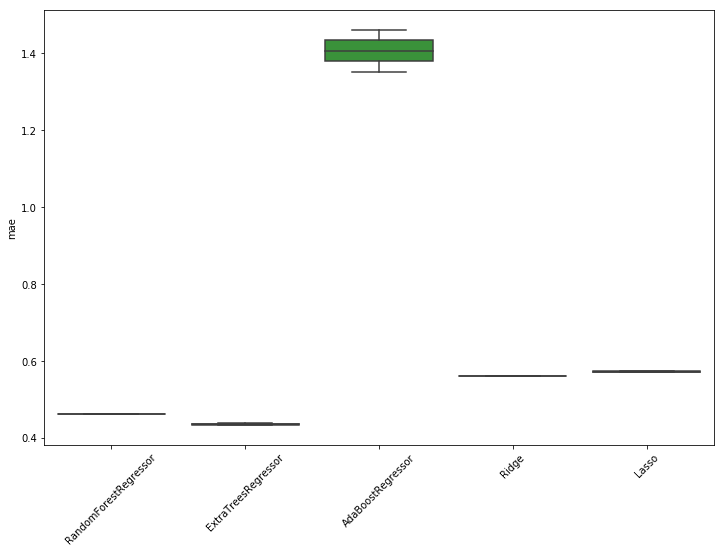

In [54]:
plt.figure(figsize=(12, 8));
scores_df = pd.DataFrame({'RandomForestRegressor': rfr_scores})
scores_df['ExtraTreesRegressor'] = etr_scores
scores_df['AdaBoostRegressor'] = abr_scores
scores_df['Ridge'] = ridge_scores
scores_df['Lasso'] = lasso_scores

sns.boxplot(data=scores_df);
plt.xticks(rotation=45);
plt.ylabel('mae')

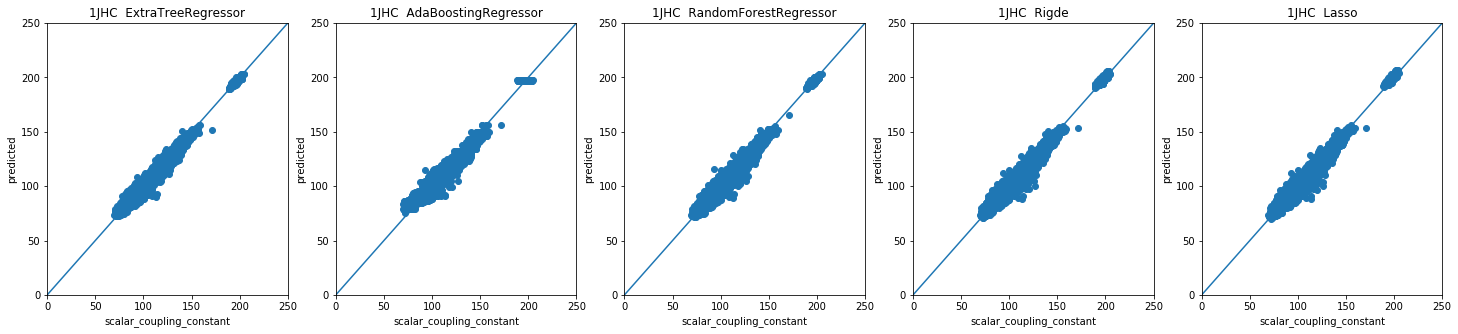

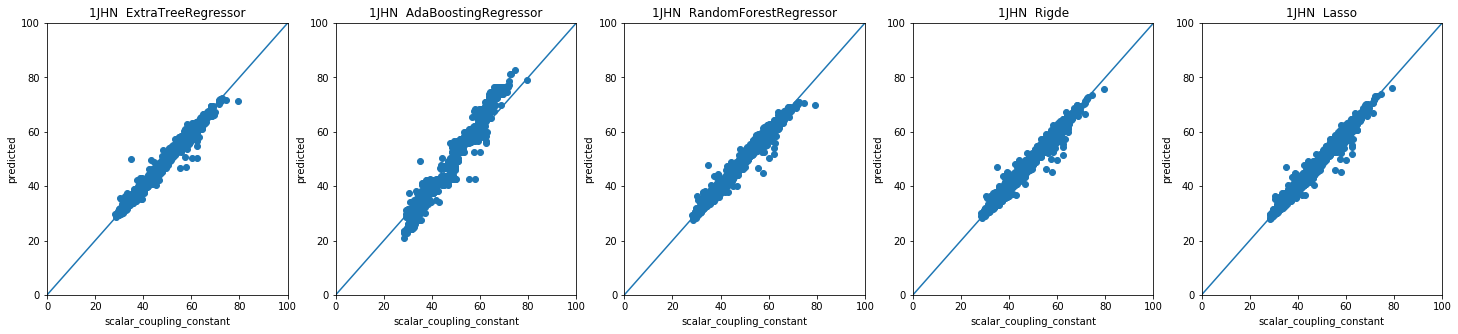

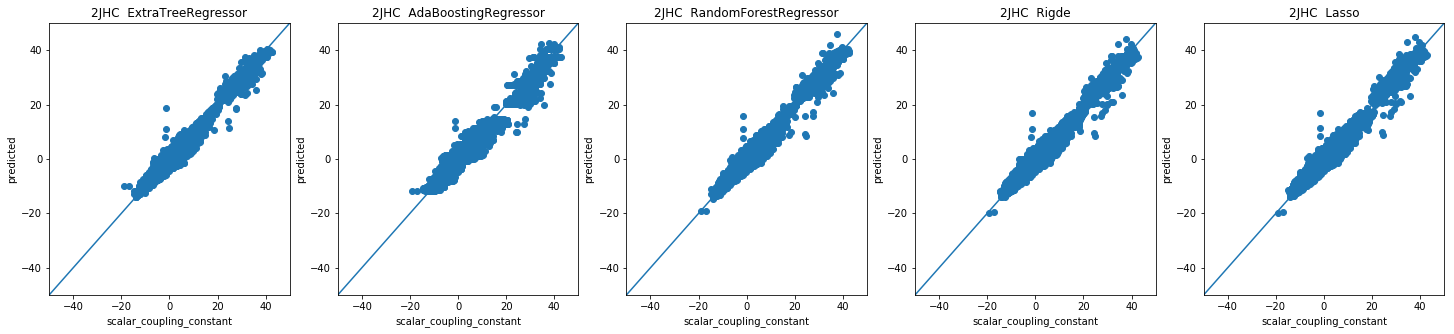

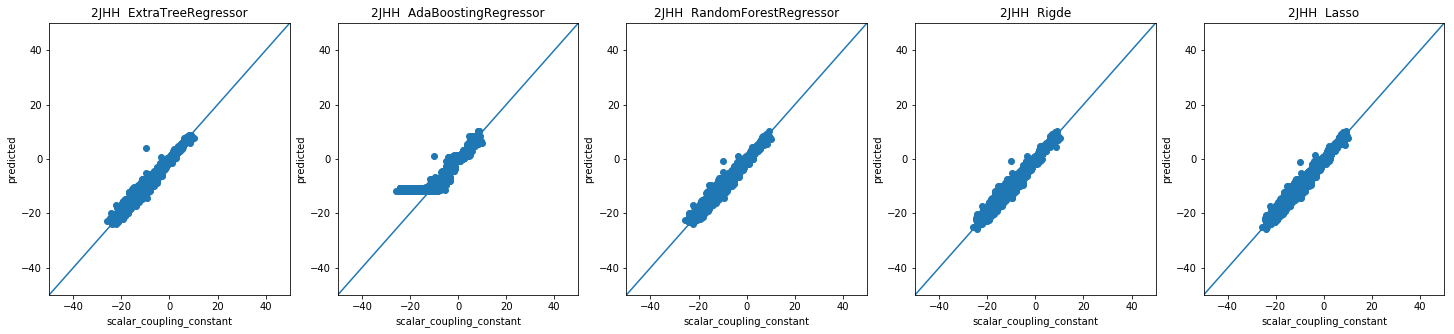

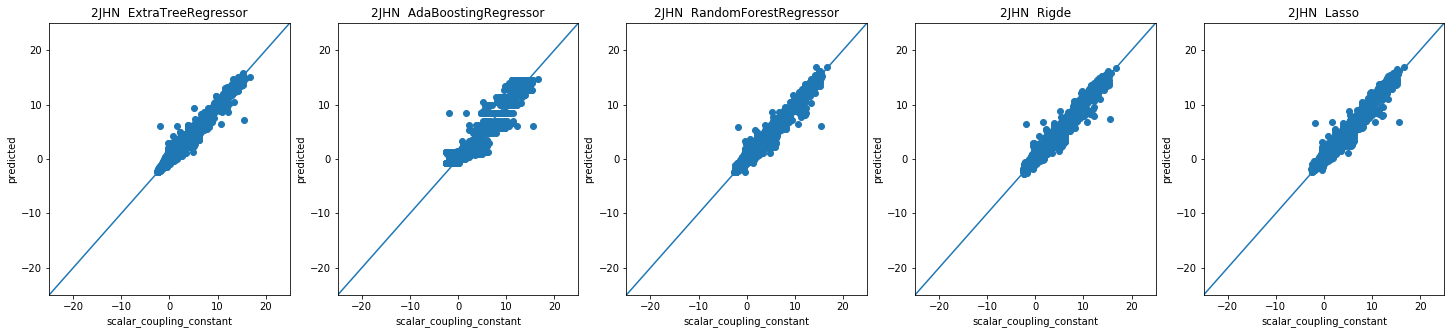

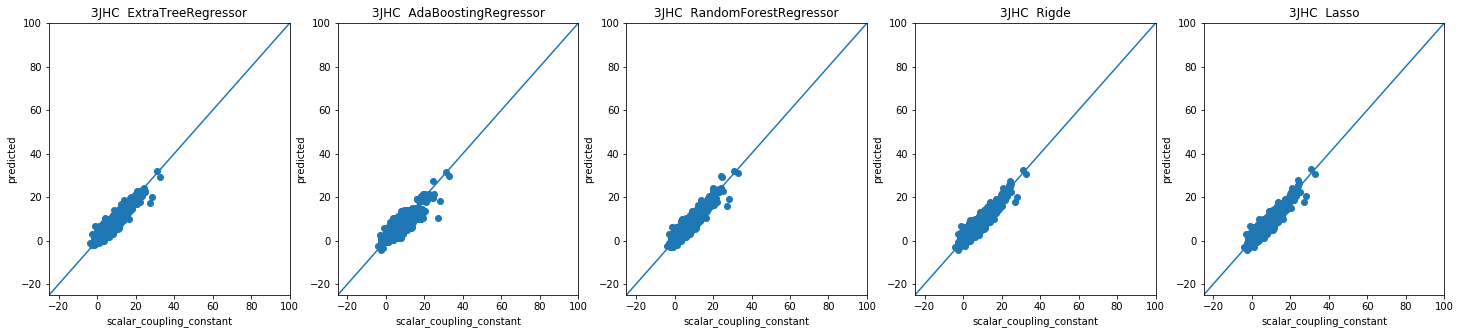

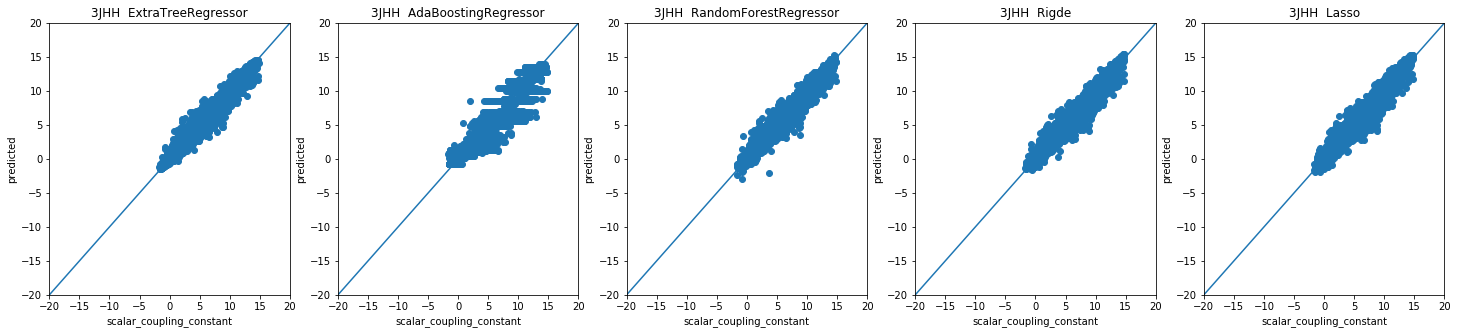

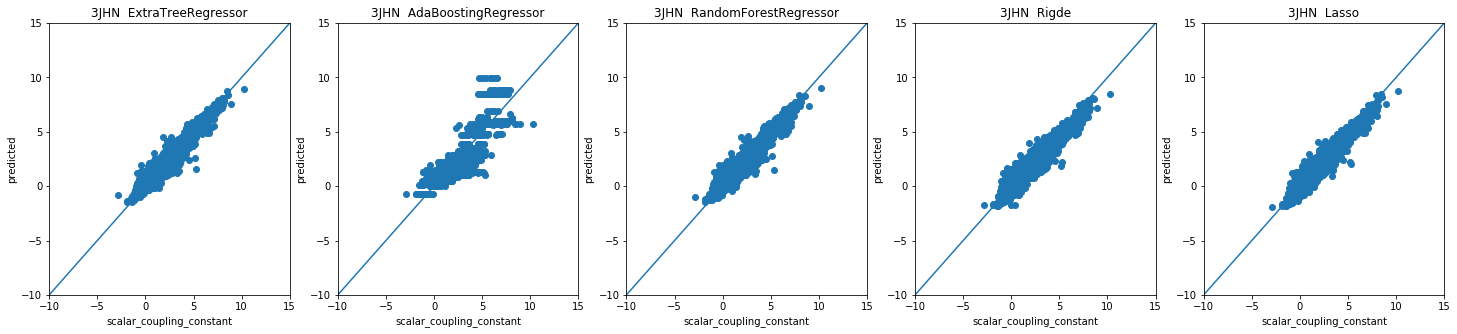

In [55]:
oof_list = [etr_oof, abr_oof, rfr_oof, ridge_oof, lasso_oof]
model_names = ['ExtraTreeRegressor', 'AdaBoostingRegressor', 'RandomForestRegressor', 'Rigde', 'Lasso']
types = lbl.inverse_transform(X['type'])

def plot_oof_preds(ctype, llim, ulim):
    fig, axs = plt.subplots(1, len(model_names), figsize=(5*len(model_names), 5))
    axs = axs.ravel()
    for i in range(len(model_names)):
        model_name = model_names[i]
        t_idx = types==ctype
        axs[i].scatter(y[t_idx], oof_list[i][t_idx])
        axs[i].set_xlim((llim, ulim))
        axs[i].set_ylim((llim, ulim))
        axs[i].plot([llim, ulim], [llim, ulim])
        axs[i].set_xlabel('scalar_coupling_constant')
        axs[i].set_ylabel('predicted')
        axs[i].set_title(f'{ctype}  {model_names[i]}', fontsize=12)
        
plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 50)
plot_oof_preds('2JHN', -25, 25)
plot_oof_preds('3JHC', -25, 100)
plot_oof_preds('3JHH', -20, 20)
plot_oof_preds('3JHN', -10, 15)